# Section 4.1 : CYCLICAL LEARNING RATES
## Summary
- Need to tune learning rate, momentum, and weight decay (L2) to get best performance
- Grid search is time consuming, but hyper parameters are tightly coupled to each other
- Too smaller a LR = overfitting, too large a LR = divergence therefore pick LR using LR range-test
- LR can then be adjusted using [cyclical learning-rates](https://arxiv.org/abs/1506.01186) (CLR)
- Large learning rates are a form of regularisation, and can lead to super-convergence
- The amount of regularisation must be balanced for each dataset and architecture, e.g. super convergence only possible if other forms of regularisation are reduced

## Cyclical Learning-Rate Example
- CLR means varying the learning rate after each minibatch between two boundaries: the optimum (as found by LRFinder), and a minimum value about 3-4 times lower than the maximum
- The simplest method is to vary the LR linearly between the bounds
- CLR helps to mitigate the risk of networks diverging at high LRs, i.e. it allows one to benefit more from the reduced underfitting of high LRs with a reduced risk of divergence
- There is a maximum rate at which the LR can be varied, before the network becomes unstable, therefore adjust the step size

Let's take the same model and train three different times:

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

Using TensorFlow backend.


In [2]:
data, features = importData()

Training on 250000 datapoints with 31 features:
['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


In [3]:
preprocParams = {'normIn':True, 'pca':False}
nFolds = 5
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'sgd', 'depth':3, 'width':128}
trainParams = {'epochs':30, 'batch_size':256, 'verbose':0}

/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '


Epoch 1/1
200000/200000 [==============================] - 2s 9us/step - loss: 5.8409e-06A: 1s

______________________________________
Training finished
LR finder took 2.978s 


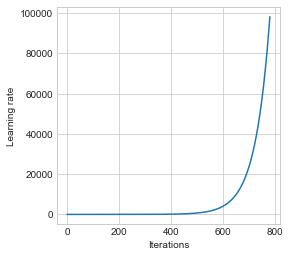

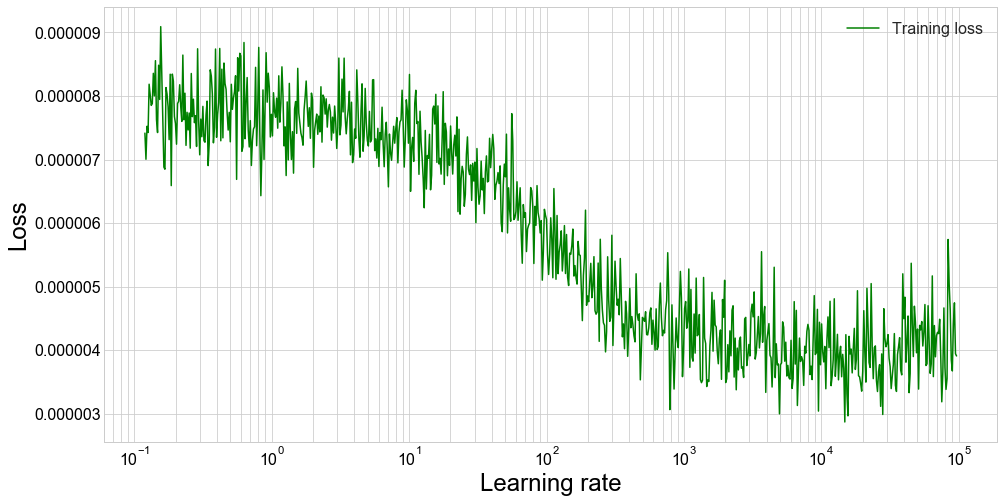

______________________________________



In [4]:
lrFinder = runLRFinder(data, features, {'version':'modelRelu', 'nIn':len(features), 'compileArgs':compileArgs}, trainParams, preprocParams, useValidation=0, lrBounds=[1e-1, 1e5]) 

Using a large LR

In [5]:
results1, history1 = cvTrainClassifier(data, features, nFolds, preprocParams,
                                       {'version':'modelRelu', 'nIn':len(features),
                                        'compileArgs':{**compileArgs, 'lr':5e3}},
                                       trainParams, useEarlyStop=False, plot=False)

Running fold 1 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '


Score is: {'loss': 3.333030754782692e-06, 'AUC': 0.9309274163341894, 'AMS': 3.400082177241733, 'cut': 0.95016754}
Fold took 50.170s

Running fold 2 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '


Score is: {'loss': 3.3300592068768465e-06, 'AUC': 0.9306476840560055, 'AMS': 3.507691428328179, 'cut': 0.9616872}
Fold took 49.539s

Running fold 3 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '


Score is: {'loss': 3.301745507669693e-06, 'AUC': 0.9318592015901588, 'AMS': 3.4556628952436177, 'cut': 0.9276278}
Fold took 50.868s

Running fold 4 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '


Score is: {'loss': 3.2823004128016643e-06, 'AUC': 0.9329371040566714, 'AMS': 3.5114680290669087, 'cut': 0.9461621}
Fold took 53.002s

Running fold 5 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '


Score is: {'loss': 3.3455261140145627e-06, 'AUC': 0.9300891088516691, 'AMS': 3.493306221062276, 'cut': 0.9465299}
Fold took 51.580s


______________________________________
Training finished
Cross-validation took 255.251s 
Mean loss = 3.32e-06 +- 1e-08
Mean AUC = 0.9313 +- 0.0004
Mean AMS = 3.47 +- 0.02
Mean cut = 0.9459999799728394 +- 0.005
______________________________________



Using an optimum LR

In [6]:
results2, history2 = cvTrainClassifier(data, features, nFolds, preprocParams,
                                       {'version':'modelRelu', 'nIn':len(features),
                                        'compileArgs':{**compileArgs, 'lr':5e2}},
                                       trainParams, useEarlyStop=False, plot=False)

Running fold 1 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '


Score is: {'loss': 3.3865771837828666e-06, 'AUC': 0.928413802164257, 'AMS': 3.298226299932155, 'cut': 0.9115581}
Fold took 51.916s

Running fold 2 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '


Score is: {'loss': 3.3459033676643564e-06, 'AUC': 0.9300047414810975, 'AMS': 3.3255584767923922, 'cut': 0.9354804}
Fold took 52.151s

Running fold 3 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '


Score is: {'loss': 3.3137272623935134e-06, 'AUC': 0.931580631975671, 'AMS': 3.400917195185693, 'cut': 0.9100797}
Fold took 53.346s

Running fold 4 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '


Score is: {'loss': 3.2893975334597856e-06, 'AUC': 0.9323131908362774, 'AMS': 3.4943981246013753, 'cut': 0.94320786}
Fold took 52.815s

Running fold 5 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '


Score is: {'loss': 3.434987328501101e-06, 'AUC': 0.9260033849801799, 'AMS': 3.237923950202172, 'cut': 0.9313651}
Fold took 53.805s


______________________________________
Training finished
Cross-validation took 264.115s 
Mean loss = 3.35e-06 +- 2e-08
Mean AUC = 0.93 +- 0.001
Mean AMS = 3.35 +- 0.04
Mean cut = 0.9259999990463257 +- 0.006
______________________________________



Using the large LR, but with CLR

Running fold 1 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '


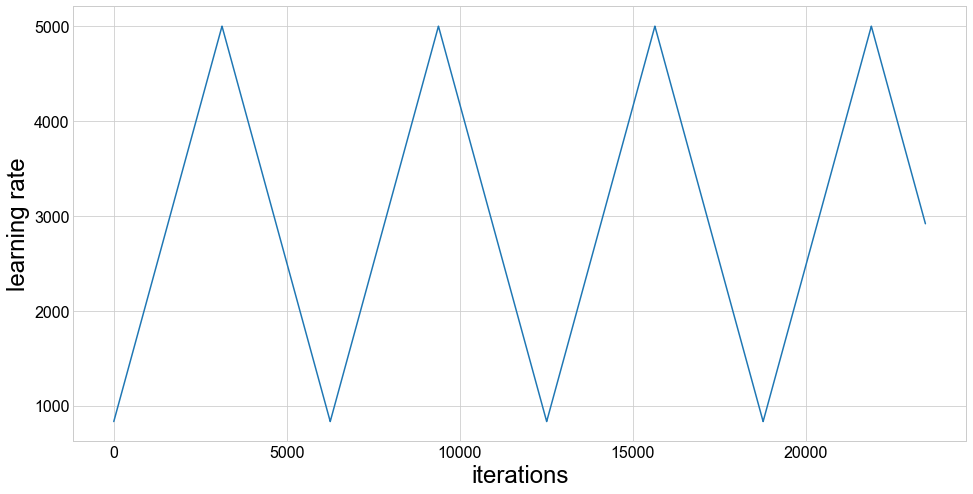

Score is: {'loss': 3.3456418299061743e-06, 'AUC': 0.9307213393721435, 'AMS': 3.4613012578918276, 'cut': 0.92733014}
Fold took 59.740s

Running fold 2 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '


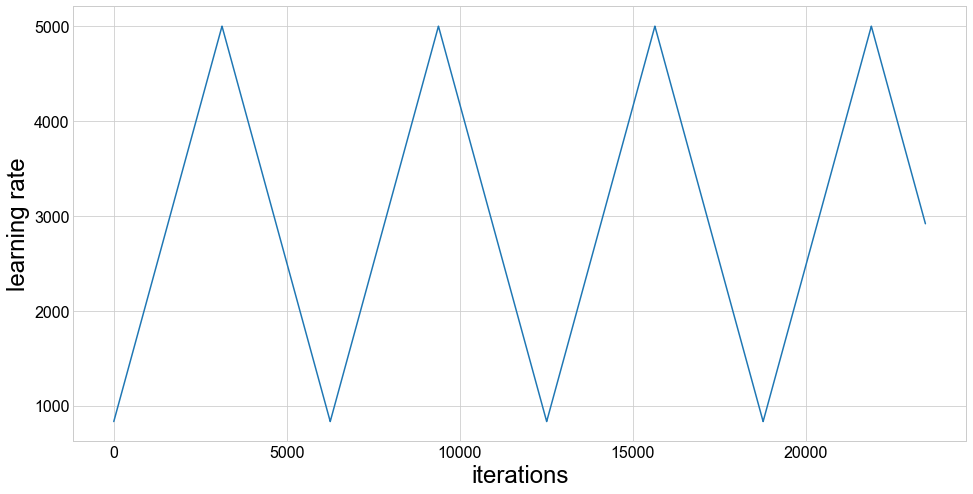

Score is: {'loss': 3.2509221041135886e-06, 'AUC': 0.9337915713845963, 'AMS': 3.7768674012429635, 'cut': 0.9536224}
Fold took 63.137s

Running fold 3 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '


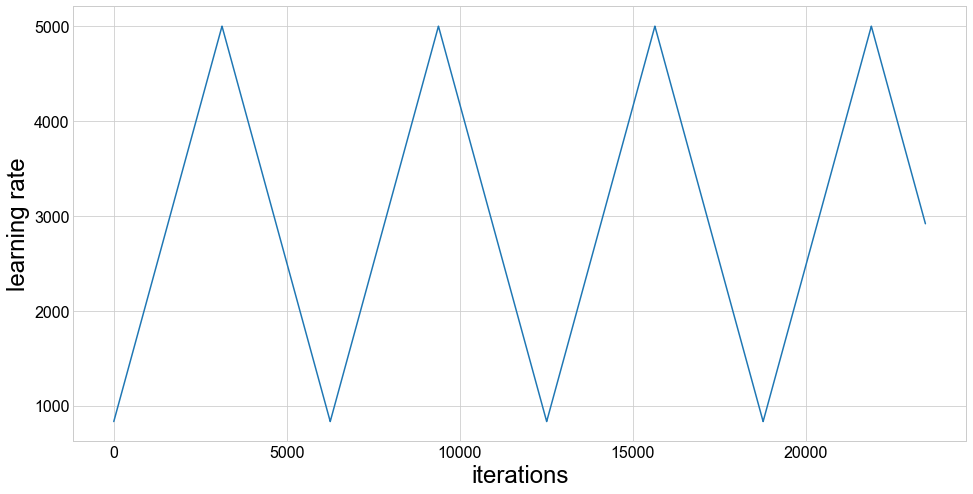

Score is: {'loss': 3.2903699079543004e-06, 'AUC': 0.9324062364598151, 'AMS': 3.58069651901712, 'cut': 0.93793845}
Fold took 61.146s

Running fold 4 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '


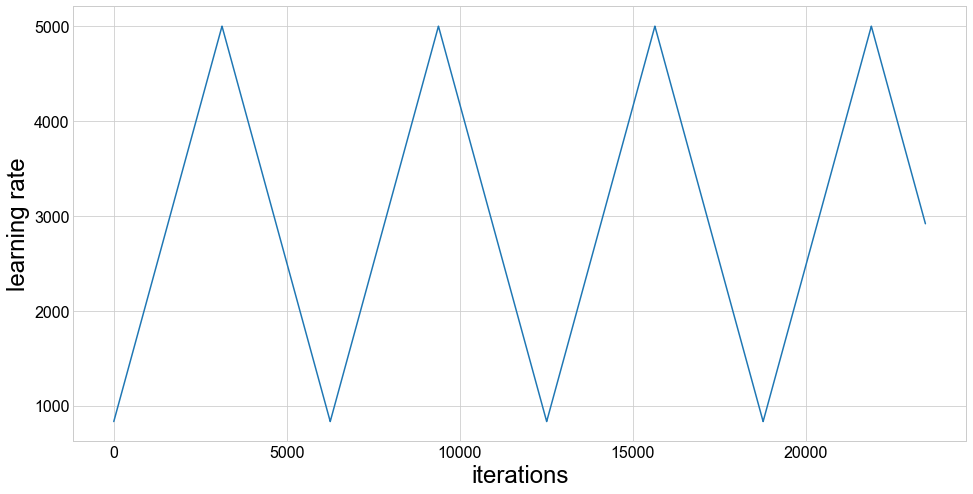

Score is: {'loss': 3.330648984347796e-06, 'AUC': 0.9300506594959492, 'AMS': 3.2548642188207824, 'cut': 0.91306216}
Fold took 61.590s

Running fold 5 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '


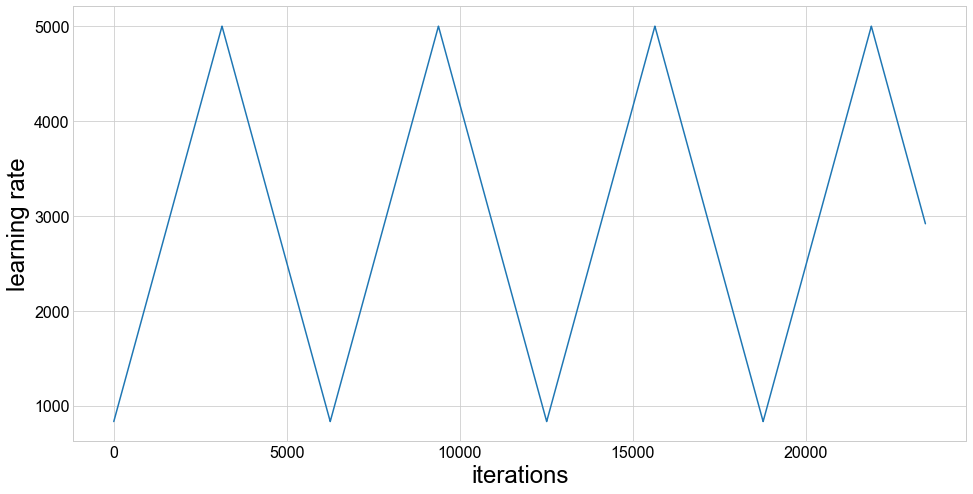

Score is: {'loss': 3.2967375930287246e-06, 'AUC': 0.9320945885612244, 'AMS': 3.3902983840778784, 'cut': 0.92588675}
Fold took 64.482s


______________________________________
Training finished
Cross-validation took 310.186s 
Mean loss = 3.3e-06 +- 1e-08
Mean AUC = 0.9318 +- 0.0006
Mean AMS = 3.49 +- 0.08
Mean cut = 0.9319999814033508 +- 0.006
______________________________________



In [7]:
lrScale=6
stepScale=4
results1CLR, history1CLR = cvTrainClassifier(data, features, nFolds, preprocParams,
                                             {'version':'modelRelu', 'nIn':len(features),
                                              'compileArgs':compileArgs},
                                             trainParams, useEarlyStop=False, plot=False,
                                             useCallbacks={'LinearCLR':{'maxLR':5e3,'minLR':(5e3)/lrScale,
                                                                        'scale':stepScale, 'plotLR':True}})

/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: User

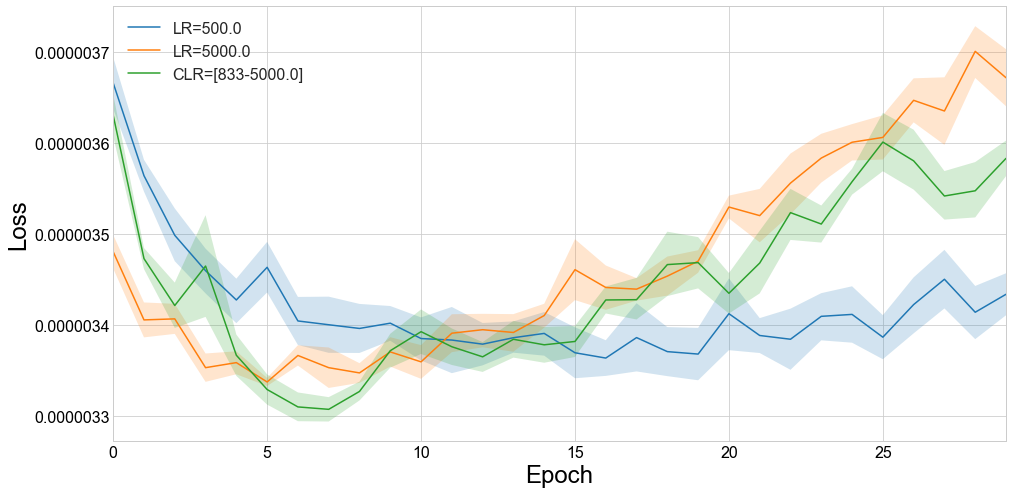

In [8]:
getModelHistoryComparisonPlot([history2, history1, history1CLR],
                              ['LR={}'.format(5e2),
                               'LR={}'.format(5e3),
                               'CLR=[{:.0f}-{}]'.format((5e3)/lrScale,  5e3)], cv=True)

Here we see that using a large, constant learning-rate (<span style="color:orange">orange</span>) exhibits instability, quickly leads to divergence, although it does slightly beat out the optimal learning-rate (<span style="color:blue">blue</span>)

Instead by cycling between a smaller LR and the large one (<span style="color:green">green</span>), we are able to converge very quickly (~6 epochs), to a better loss than the constant, optimum LR. Although the CLR does display a bit of instability, so further parameter tuning might be needed.

### Cosine Annealing with restarts
While not mentioned in the paper, we can instead anneal the LR according to a cosine function, and then jumping up to the maximum LR at 0. Decaying the learning rate, allows one to make use of large initial learning-rates for quick convergence, and smaller learning-rates to arrive at the minima.
Additionally, the discrete changes at lr=0, may be used to jump out of narrow minima (which have poor generalisation) to eventually arrive in wider minima (better generalisation). They can even be used to build an ensemble from a single training, via [snapshot ensembling](https://arxiv.org/abs/1704.00109). The Fast.AI course also gives a good explanation of these points [here](https://youtu.be/JNxcznsrRb8?t=30m33s)

Running fold 1 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '


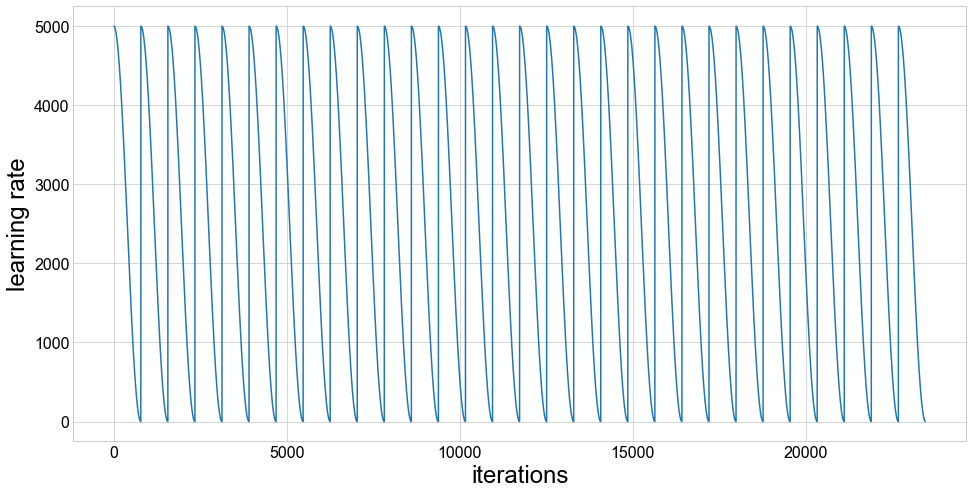

Score is: {'loss': 3.326831372205063e-06, 'AUC': 0.9305671413823742, 'AMS': 3.441377329481109, 'cut': 0.94233346}
Fold took 60.538s

Running fold 2 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_bat

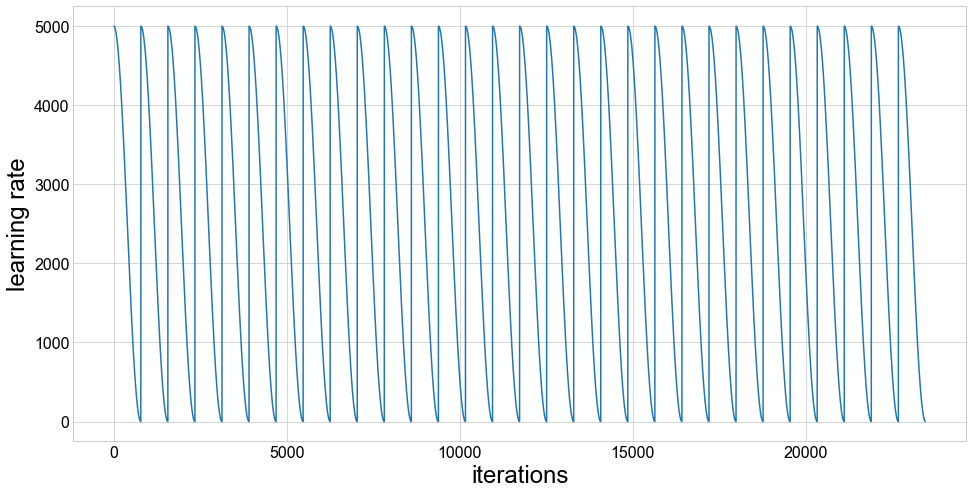

Score is: {'loss': 3.2809312346209046e-06, 'AUC': 0.9326650075409582, 'AMS': 3.5864948342403613, 'cut': 0.952196}
Fold took 61.976s

Running fold 3 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_bat

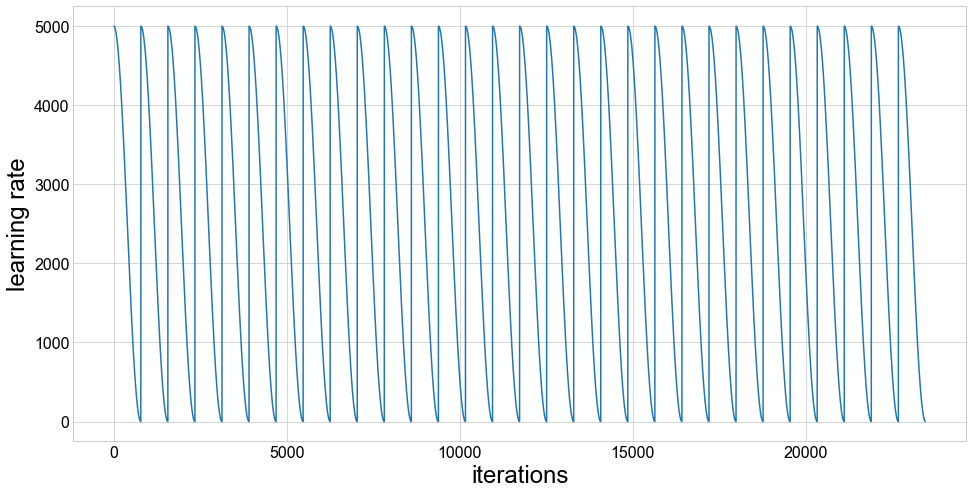

Score is: {'loss': 3.2566724088974297e-06, 'AUC': 0.9335198108153793, 'AMS': 3.62761285111231, 'cut': 0.9478317}
Fold took 62.053s

Running fold 4 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_bat

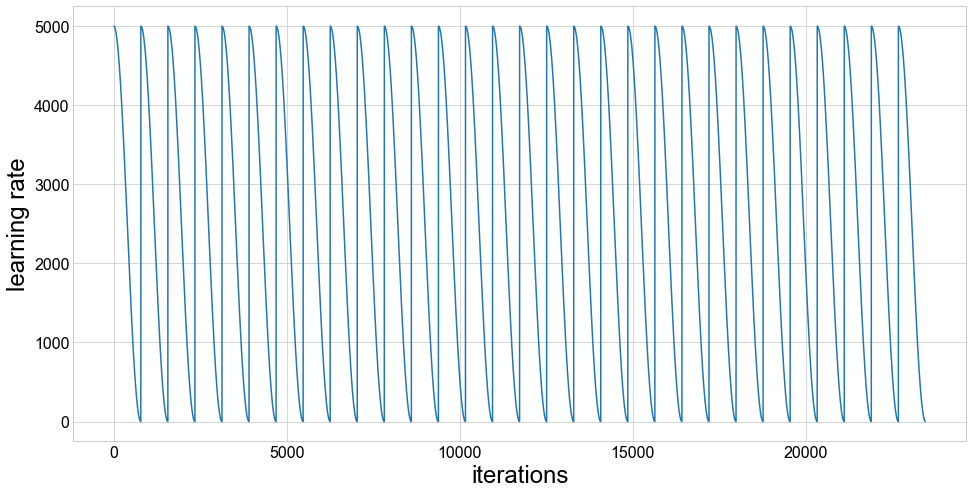

Score is: {'loss': 3.2728558315792333e-06, 'AUC': 0.9335557232503061, 'AMS': 3.6603289605608142, 'cut': 0.94138455}
Fold took 63.694s

Running fold 5 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_bat

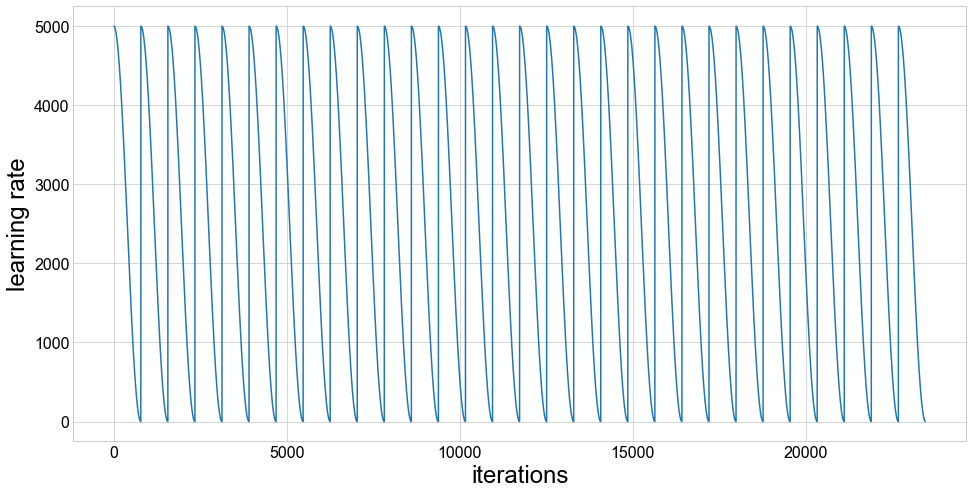

Score is: {'loss': 3.2721436413017976e-06, 'AUC': 0.9327444565581358, 'AMS': 3.431280563909179, 'cut': 0.9473926}
Fold took 62.421s


______________________________________
Training finished
Cross-validation took 310.774s 
Mean loss = 3.28e-06 +- 1e-08
Mean AUC = 0.9326 +- 0.0005
Mean AMS = 3.55 +- 0.04
Mean cut = 0.9459999799728394 +- 0.002
______________________________________



In [9]:
results1Cos, history1Cos = cvTrainClassifier(data, features, nFolds, preprocParams,
                                             {'version':'modelRelu', 'nIn':len(features),
                                              'compileArgs':{**compileArgs, 'lr':5e3}},
                                             trainParams, useEarlyStop=False, plot=False,
                                             useCallbacks={'CosAnnealLR':{'plotLR':True}})

/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: User

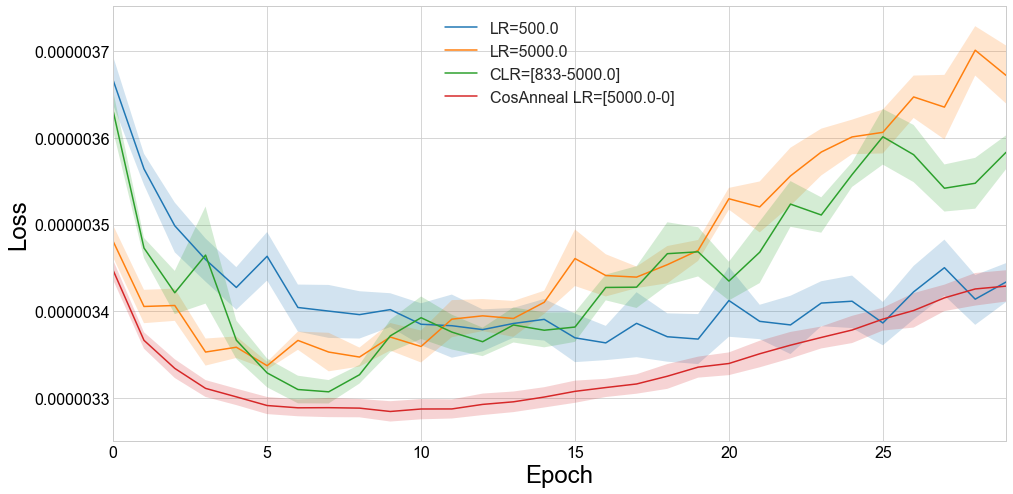

In [10]:
getModelHistoryComparisonPlot([history2, history1, history1CLR, history1Cos],
                              ['LR={}'.format(5e2),
                               'LR={}'.format(5e3),
                               'CLR=[{:.0f}-{}]'.format((5e3)/lrScale, 5e3),
                               'CosAnneal LR=[{}-0]'.format(5e3)], cv=True)

Using cosine annealing with restarts (<span style="color:red">red</span>), we're able to reach a slightly better loss than the linear cycle performance (<span style="color:green">green</span>), in about the same time. However, the validation loss is much more stable (smoother line), which perhaps indicates that it is able to more easily find wider minima.

We can even adjust the `cycle_mult` parameter to cause the cycle length to double or triple after each cycle, to make it easier to coverge to the centres of the wider minima.

### Super convergence

Section 4.1 then goes on to mention _super convergence_, in which a single LR cycle (with momentum also evolving in the opposite direction) is used to reach optimum performanace about 8 times quicker. I have tried to get this to work, but so far have been without success. Possibly the architecture and problem are too simple here (the paper uses deep resnets on cifar-10).

It could also be that CLR is already exhibiting super-convergence (it reaches it's minimum much quicker than a constant LR), and so using the specifically designed super-convergence policy does not offer any benefit here.

Running fold 1 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_bat

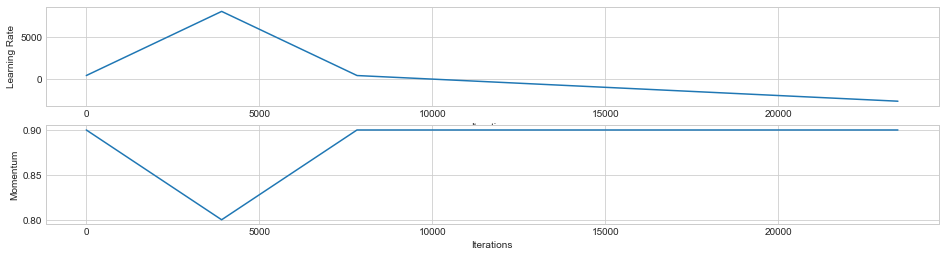

Score is: {'loss': 3.3166301325487297e-06, 'AUC': 0.9315995321466413, 'AMS': 3.4641540872761523, 'cut': 0.94826156}
Fold took 70.612s

Running fold 2 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_bat

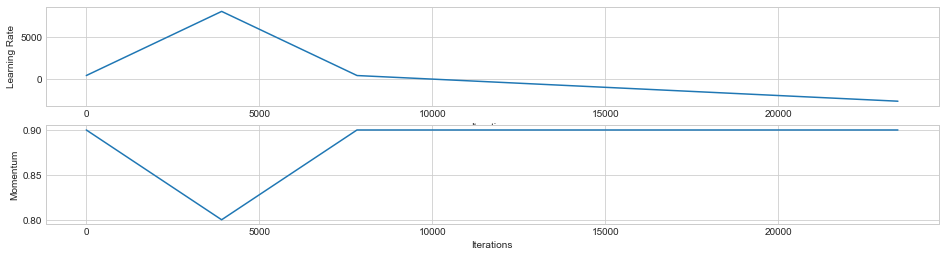

Score is: {'loss': 3.3552068664273385e-06, 'AUC': 0.92960231282184, 'AMS': 3.3286621734104056, 'cut': 0.9476413}
Fold took 71.997s

Running fold 3 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_bat

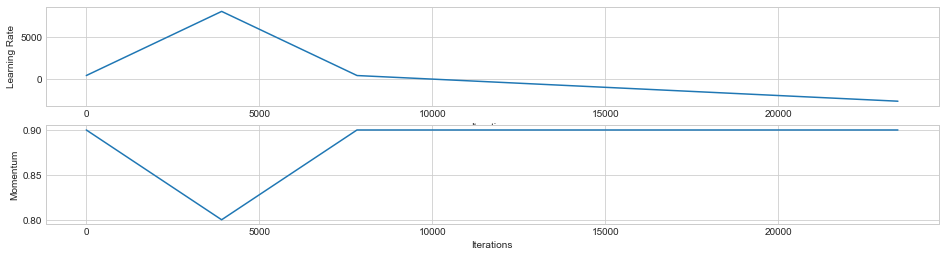

Score is: {'loss': 3.2663050581686547e-06, 'AUC': 0.9338362630533078, 'AMS': 3.6536456730559963, 'cut': 0.94023746}
Fold took 71.434s

Running fold 4 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_bat

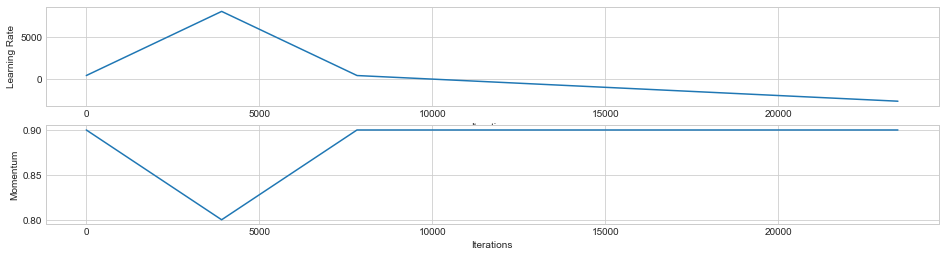

Score is: {'loss': 3.308542580435427e-06, 'AUC': 0.9321605330393288, 'AMS': 3.522335912642831, 'cut': 0.96234465}
Fold took 71.189s

Running fold 5 / 5


/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:481: UserWarning: Found both `sample_weight` and `class_weight`: `class_weight` argument will be ignored.
  warnings.warn('Found both `sample_weight` and `class_weight`: '
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_bat

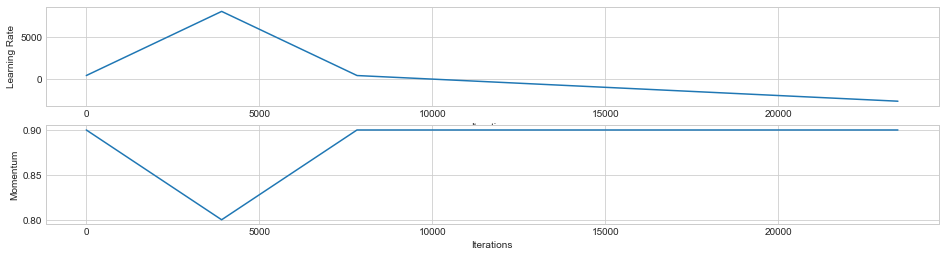

Score is: {'loss': 3.311120016882515e-06, 'AUC': 0.9322893801701679, 'AMS': 3.710649948593926, 'cut': 0.95908916}
Fold took 72.632s


______________________________________
Training finished
Cross-validation took 357.954s 
Mean loss = 3.31e-06 +- 1e-08
Mean AUC = 0.9319 +- 0.0006
Mean AMS = 3.54 +- 0.06
Mean cut = 0.9520000219345093 +- 0.004
______________________________________



In [11]:
results3One, history3One = cvTrainClassifier(data, features, nFolds, preprocParams,
                                             {'version':'modelRelu', 'nIn':len(features),
                                              'compileArgs':{**compileArgs, 'lr':8e3}},
                                             trainParams, useEarlyStop=False, plot=False,
                                             useCallbacks={'OneCycle':{'scale':10, 'lrScale':20,
                                                                       'momScale':0.1, 'plot':True}})

/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: User

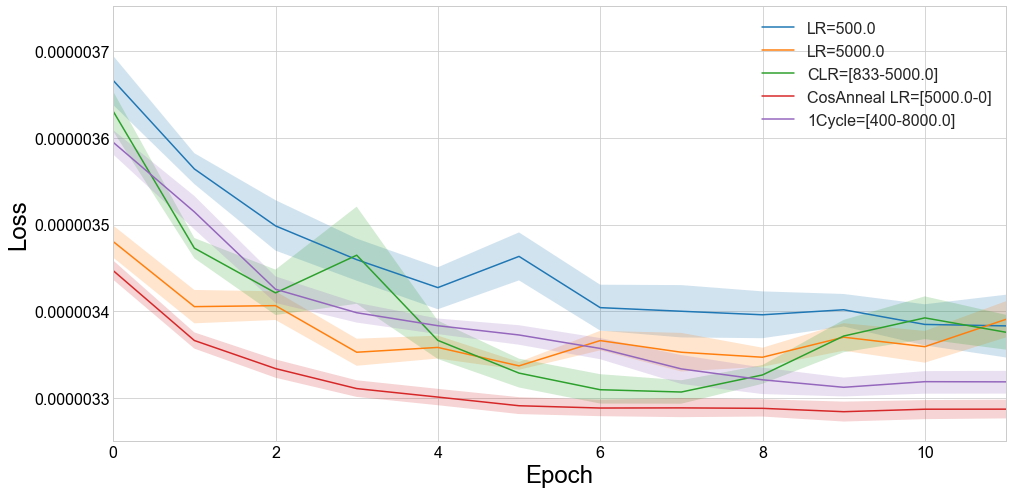

In [12]:
getModelHistoryComparisonPlot([history2, history1, history1CLR, history1Cos,
                               [{'val_loss':x['val_loss'][:12]} for x in history3One]],
                              ['LR={}'.format(5e2),
                               'LR={}'.format(5e3),
                               'CLR=[{:.0f}-{}]'.format((5e3)/lrScale, 5e3),
                               'CosAnneal LR=[{}-0]'.format(5e3),
                               '1Cycle=[{:.0f}-{}]'.format(8e3/20, 8e3)], cv=True)

Using 1cycle scheduling (<span style="color:purple">purple</span>), we get a similar trend to the CLR loss (<span style="color:green">green</span>), but it is more stable, but is slower to converge. There are several hyperparameters to tune for it, but I think that CLR is already displaying super-convergence, so 1cycle is unlikely to offer much benefit for this architecture and dataset.